In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 10
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 2.85360590e-03-1.54292583e-02j  2.72931289e-02-2.22314009e-03j
  -2.99348170e-03-1.49390008e-02j  1.36174206e-02-1.09343790e-02j
   2.23175762e-03+3.80806043e-03j -8.34464375e-03+5.30528557e-03j
   1.88120157e-02-4.37240768e-03j -6.68907166e-03-8.41840636e-03j
  -5.38586173e-03+8.02218542e-03j  6.23587100e-03-9.75812040e-03j]
 [-1.51609397e-02+4.06018365e-03j -1.20811397e-02+1.59488376e-02j
  -5.24524180e-03+9.57588141e-04j -5.63835027e-03-3.03776073e-03j
   2.48767762e-03-6.28373818e-03j  7.73068424e-03-8.15780926e-03j
   1.05273249e-02-5.59913414e-03j  2.78886016e-02+8.10511177e-04j
   2.16649356e-03-1.73993707e-02j -2.20440025e-03+1.14874616e-02j]
 [ 6.06457100e+01+1.05320415e+01j  9.98715591e+01+2.63866119e+01j
  -2.04313844e-02-2.14899890e-02j  1.82281644e-03-1.67929567e-02j
   6.69598160e-03+5.51857147e-03j  4.77387896e-03+5.89219807e-03j
   4.96393023e-03-3.48758348e-03j  5.96479233e-03-2.16951128e-03j
  -5.99652389e-03+1.27402600e-02j  2.33361758e-02-1.96958259e-02j]
 [ 7.15

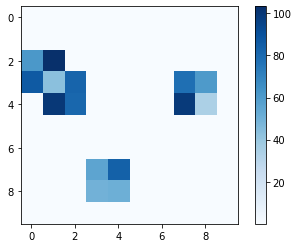

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 667.9715   +7.14202820e+02j  239.88922  -7.35217896e+01j
   196.1454   -3.09211517e+02j  348.0024   -2.15206863e+02j
  -101.85069  +5.22129784e+01j   64.12078  -3.77572670e+01j
    58.18294  +3.37511024e+01j  -62.73501  +2.73481018e+02j
  -159.62523  -1.93031052e+02j   71.12421  +3.51044525e+02j]
 [ 242.92065  -5.44892334e+02j  283.91776  -3.36648743e+02j
  -521.8105   -1.80494049e+02j -268.61072  -7.76528473e+01j
   129.03241  -7.28777771e+01j  -10.709249 +8.64734573e+01j
   -15.567456 -1.94897400e+02j  129.77586  +1.74913269e+02j
   431.80838  +3.05180115e+02j  132.3747   -5.35446655e+02j]
 [-788.8265   -1.30559341e+02j -298.69382  +8.28332748e+01j
   188.97638  +1.49649124e+02j -160.1652   +2.25919205e+02j
  -110.79906  -7.61805649e+01j    6.2096267-4.22292252e+01j
    51.70953  +1.06899925e+02j  -66.81033  -3.75149445e+02j
    10.908684 -2.59052734e+02j -128.3106   -1.00515816e+02j]
 [ 231.84618  +3.15029419e+02j -147.15022  +2.11923935e+02j
    28.814611 -5.76573753e+01j  133.4

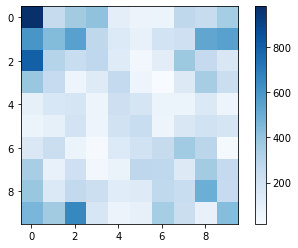

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 3) Source-finding classification

### Training labels

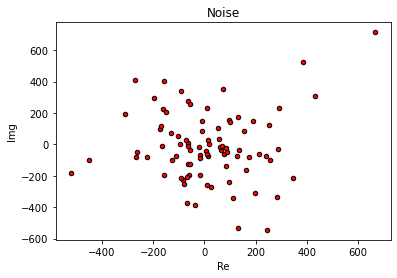

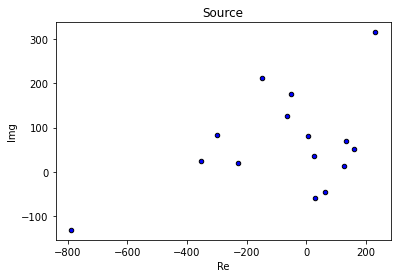

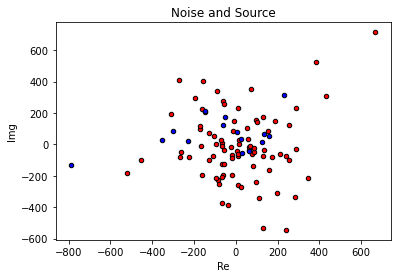

In [6]:
def labels(data, mask):
    
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, ax=None):
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise')
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Source')
    plt.show()
    
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise and Source')
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
plot_data(Xdata, ydata)


# Define output labels as quantum state vectors
def density_matrix(state):
    
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [7]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches

In [8]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the visibilities

In [9]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
indices = []
for i in range(0, len(X_data)):
    indices.append(i)
random.shuffle(indices)

for i in range(0, len(X_data)):
    X_data[i] = X_data[indices[i]]
    y_data[i] = y_data[indices[i]]

index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 2
learning_rate = 1e-3
epochs = 20
batch_size = 64

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in tqdm(iterate_minibatches(X_train, y_train, batch_size=batch_size)):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

0it [00:00, ?it/s]

Epoch:  0 | Cost: 0.132911 | Train accuracy: 0.712500 | Test Accuracy: 0.800000


1it [00:02,  2.69s/it]
0it [00:00, ?it/s]

Epoch:  1 | Loss: 0.213616 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  5.00s/it]
0it [00:00, ?it/s]

Epoch:  2 | Loss: 0.213513 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.92s/it]
0it [00:00, ?it/s]

Epoch:  3 | Loss: 0.213411 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.96s/it]
0it [00:00, ?it/s]

Epoch:  4 | Loss: 0.213309 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  5.00s/it]
0it [00:00, ?it/s]

Epoch:  5 | Loss: 0.213207 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.94s/it]
0it [00:00, ?it/s]

Epoch:  6 | Loss: 0.213105 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.96s/it]
0it [00:00, ?it/s]

Epoch:  7 | Loss: 0.213003 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:05,  5.10s/it]
0it [00:00, ?it/s]

Epoch:  8 | Loss: 0.212901 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.92s/it]
0it [00:00, ?it/s]

Epoch:  9 | Loss: 0.212800 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.87s/it]
0it [00:00, ?it/s]

Epoch: 10 | Loss: 0.212699 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.81s/it]
0it [00:00, ?it/s]

Epoch: 11 | Loss: 0.212598 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.92s/it]
0it [00:00, ?it/s]

Epoch: 12 | Loss: 0.212498 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.62s/it]
0it [00:00, ?it/s]

Epoch: 13 | Loss: 0.212398 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.71s/it]
0it [00:00, ?it/s]

Epoch: 14 | Loss: 0.212297 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.72s/it]
0it [00:00, ?it/s]

Epoch: 15 | Loss: 0.212198 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.76s/it]
0it [00:00, ?it/s]

Epoch: 16 | Loss: 0.212098 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.60s/it]
0it [00:00, ?it/s]

Epoch: 17 | Loss: 0.211999 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.71s/it]
0it [00:00, ?it/s]

Epoch: 18 | Loss: 0.211900 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  5.00s/it]
0it [00:00, ?it/s]

Epoch: 19 | Loss: 0.211801 | Train accuracy: 0.712500 | Test accuracy: 0.800000


1it [00:04,  4.87s/it]


Epoch: 20 | Loss: 0.211703 | Train accuracy: 0.712500 | Test accuracy: 0.800000


### Results

Cost: 0.211703 | Train accuracy 0.712500 | Test Accuracy : 0.800000
Learned weights
Layer 0: [0.48822101 0.74447884 0.70758133]
Layer 1: [0.05503633 0.83890675 0.81102833]


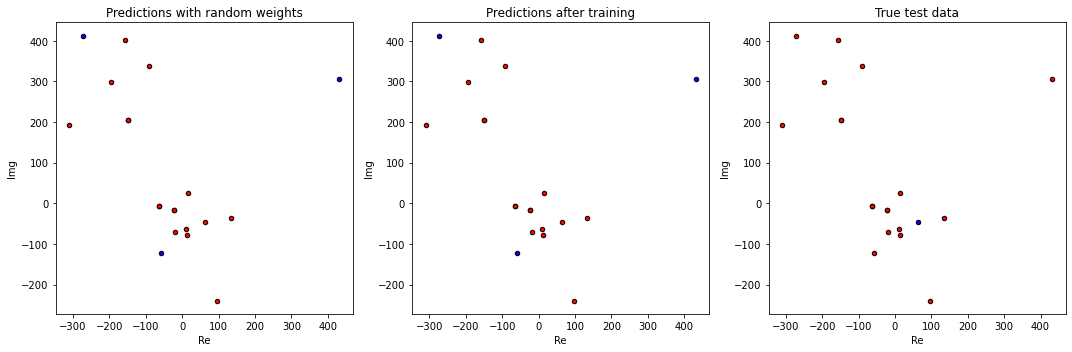

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
reds = initial_predictions == 0
blues = initial_predictions == 1
axs[0].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[0].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = predicted_test == 0
blues = predicted_test == 1
axs[1].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[1].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = y_test == 0
blues = y_test == 1
axs[2].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[2].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")

axs[0].set_title("Predictions with random weights")
axs[1].set_title("Predictions after training")
axs[2].set_title("True test data")

for ax in axs.flat:
    ax.set(xlabel='Re', ylabel='Img')

plt.tight_layout()
plt.show()

print(predicted_test - initial_predictions)